In [0]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

**Downloading the dataset**

In [0]:
iris = datasets.load_iris()
ratio_train = 0.8
train_samples = int(len(iris.data) * ratio_train)
X = iris.data
y = to_categorical(iris.target)  # one-hot-encoding for dataset
x_train,  x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Defining network layers parameters**

In [0]:
input_size = x_train.shape[1]
first_layer_units = 8
second_layer_units = 8
number_of_classes = y_train[0].shape[0] 

In [0]:
from keras.models import Sequential
from keras import models
from keras.layers import Dense, Activation
from keras.optimizers import adam
import matplotlib.pyplot as plt
import math

**Defining the neural network**

In [0]:
def model():
    model = Sequential()
    model.add(Dense(units=first_layer_units, input_dim=input_size, activation='relu', name="first"))
    model.add(Dense(units=second_layer_units, input_dim=first_layer_units, activation='sigmoid', name="second"))
    model.add(Dense(units=3, activation='softmax', name="last"))

    adam_optimizer = adam(lr=.001)

    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [0]:
model = model()
T = 3  # initial temperature
T_cold = 1e-12  # temperature after which the sa will stop
a1 = 0.8  # first coefficient (T*a1 when T >= 0.08) 
a2 = 0.85  # second (T*a2 when T >= 0.02)
a3 = 0.85  # third (else)
iters_number = 40  # after this number of iterations process will stop  

**Implementation of SA for the neural network weights**

In [30]:
def P_star(new_loss, old_loss, T):
  ### energy function that is p*(x) in the task
  return math.exp((old_loss - new_loss)/T)


def init_model_weights(model):
  ### model initialization with random weights with mean 0 and std 1
  for i in range(len(model.layers)):
    layer = list()
    weights = np.array(model.layers[i].get_weights()[0])
    bias = np.array(model.layers[i].get_weights()[1])
    layer = [np.random.randn(*weights.shape), np.random.randn(*bias.shape)]
    if len(layer) > 0:
      model.layers[i].set_weights(layer)
  return model


def simulated_annealing(model, T_cold=1e-6, iters_number=20, T=2, a1=0.8, a2=0.85, a3=0.9):
  ### sa method implementation for optimizing defined neural network weights
  ### for the iris dataset classification task
  iters = iters_number
  loss, acc = model.evaluate(x_train, y_train)
  loss_history = list()
  acc_history = list()
  while T > T_cold and iters > 0:
    model_copy = models.clone_model(model)
    model_copy.set_weights(model.get_weights())
    for i in range(len(model.layers)):
      rand_step = list()
      weights = np.array(model.layers[i].get_weights()[0])
      bias = np.array(model.layers[i].get_weights()[1])
      rand_step = [np.random.randn(*weights.shape), np.random.randn(*bias.shape)]
      model_copy.layers[i].set_weights([weights + rand_step[0], bias + rand_step[1]])
    model_copy.build((None, 4)) 
    model_copy.compile(optimizer=adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    new_loss, new_acc = model_copy.evaluate(x_train, y_train)
    old_loss, old_acc = loss, acc
    u = np.random.rand()
    loss, acc = -1, -1
    if u < P_star(new_loss, old_loss, T):
      if new_loss > old_loss:
        print("u = {0} < {1} = P, new - old = {2}".format(u, P_star(new_loss, old_loss, T), new_loss-old_loss))
      model = model_copy
      loss = new_loss
      acc = new_acc
    else:
      loss = old_loss
      acc = old_acc
    loss_history.append(loss)
    acc_history.append(acc)
    print("loss = {0}, current temp = {1}, iteration {2}".format(loss, T, iters_number - iters))
    if T > 0.08: 
      T *= a1
    elif T > 0.02:
      T *= a2
    else:
      T *= a3
    iters -= 1
  return model, loss_history, acc_history, T

model = init_model_weights(model)
model, loss_history, acc_history, T = simulated_annealing(model, T_cold, iters_number, T, a1, a2, a3)

120/120 [==============================] - 1s 12ms/step
u = 0.22665040991463692 < 0.8732848476179107 = P, new - old = 0.4064804712931316
loss = 1.3829103549321493, current temp = 3, iteration 0
120/120 [==============================] - 1s 12ms/step
loss = 1.3829103549321493, current temp = 2.4000000000000004, iteration 1
120/120 [==============================] - 1s 12ms/step
u = 0.22356997148418112 < 0.8721948985989026 = P, new - old = 0.26254535516103106
loss = 1.6454557100931804, current temp = 1.9200000000000004, iteration 2
120/120 [==============================] - 1s 12ms/step
loss = 1.2333523670832316, current temp = 1.5360000000000005, iteration 3
120/120 [==============================] - 2s 13ms/step
loss = 1.2333523670832316, current temp = 1.2288000000000006, iteration 4
120/120 [==============================] - 1s 12ms/step
loss = 1.2333523670832316, current temp = 0.9830400000000005, iteration 5
120/120 [==============================] - 1s 12ms/step
loss = 0.729702850

**Final performance and history demonstration:**

30/30 [==============================] - 0s 136us/step
final temperature: 0.0016080010389340948, final loss: 0.3711, final accuracy: 77.78%


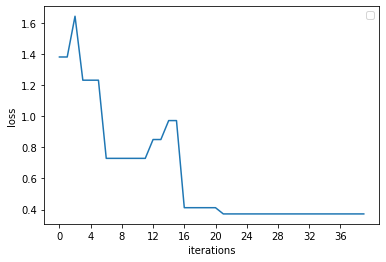

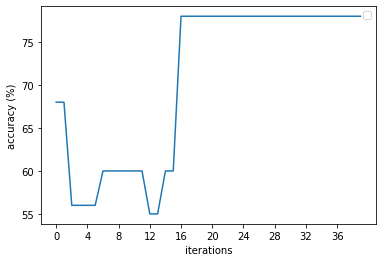

In [32]:
def round_acc(x):
  return round(x, 2) * 100

result = model.evaluate(x_test, y_test)
print("final temperature: {2}, final loss: {0}, final accuracy: {1}%".format(round(result[0], 4), 100*round(result[1], 4), T))
plt.legend("Loss progress")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.xticks(range(0, iters_number, iters_number//10))
plt.plot(loss_history)
plt.show()

plt.legend("Accuracy progress")
plt.xlabel("iterations")
plt.ylabel("accuracy (%)")
plt.xticks(range(0, iters_number, max(1, iters_number//10)))
plt.plot(list(map(round_acc, acc_history)))
plt.show()